In [1]:
import sys
sys.path.append('./resonator_code')

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import Labber
import numpy as np
import os
import matplotlib.pyplot as plt
from fitTools.Resonator import Resonator
import logging

In [11]:
def fit_resonator(fpath:str,res_type:str = "n"):
    plt.rcParams.update({'font.size':14})

    # fpath = input("Path to .hdf5 file: ").replace('"','')
    # res_type = input("What is the resonator type? [\"n\" for notch, \"r\" for reflection, and \"t\" for transmission]: \n")
    if res_type not in ["r","t","n"]:
        res_type = "n"
        print("Notch type resonator used by default")
    path,fname = os.path.split(fpath)
    path += r'\\'
    figpath = 'figures\\'+fname[:-4]+'\\'
    if not os.path.exists(path+'figures\\'):
        os.mkdir(path+'figures\\')
    if not os.path.exists(path+figpath):
        os.mkdir(path+figpath)
    lf = Labber.LogFile(path + fname)

    logFileName = path + f"profile_info_{fname[:-4]}log"
    logging.basicConfig(level=logging.INFO, format='%(message)s')
    logger = logging.getLogger()
    logger.addHandler(logging.FileHandler(logFileName, 'a'))
    print = logger.info

    nEntries = lf.getNumberOfEntries()
    pow_offset = 40 # Attens after VNA 
    power = lf.getStepChannels()[0]["name"]

   # a = 0
   # b = 0

    fits = {'f':[],'Q':[],'Qint':[],'Qext':[]}
    for n in range(nEntries):
        (xdata,ydata) = lf.getTraceXY(entry = n)
        res = Resonator(res_type, xdata,ydata)
        #res.autofit(fcrop=(6.471,6.477),force_calibrate=True)
        res.autofit()
        fits['f'].append(res.f0*1e-9)
        fits['Q'].append(res.Q)
        fits['Qint'].append(res.Qi)
        fits['Qext'].append(res.Qc)

        if res.fit_found:
            print(20*"=")
            res.show(savefile = path+figpath+fname[:-4]+'resonance_{}-dBm.png'.format(power[n]))
            print('\nFit at {} dBm'.format(power[n]))
            print(res)
            print(20*"="+"\n")


    fig = plt.figure(figsize=[9,6],constrained_layout=True)
    
    print(f"Q_ext = {fits['Qext']}, Q_int = {fits['Qint']}, Q_tot = {fits['Q']}")
    
    # #plt.plot(power + pow_offset,fits['f'],'r.')
    # plt.title('Frequency vs power')
    # #plt.xlabel('VNA Power [dBm]')
    # plt.xlabel('Power on device [dBm]')
    # #plt.xlabel('LO attenuation [dB]')
    # plt.ylabel('Frequency from fit [GHz]')
    # #plt.savefig(path+figpath+fname[:-4]+'_f0-vs-P.png')
    # plt.show()
    
    # fig = plt.figure(figsize=[9,6],constrained_layout=True)
    # plt.scatter(power + pow_offset,fits['Q'],s=20,c='r',label='Total Q')
    # plt.scatter(power + pow_offset,fits['Qint'],s=20,c='b',label='Internal Q')
    # plt.scatter(power + pow_offset,fits['Qext'],s=20,c='g',label='external Q')
    # plt.title('Q vs power')
    # #plt.xlabel('VNA Power [dBm]')
    # plt.xlabel('Power on device [dBm]')
    # #plt.xlabel('LO attenuation [dB]')
    # plt.ylabel('Quality factor')
    # plt.legend()
    # #plt.savefig(path+figpath+fname[:-4]+'_Q-vs-P.png')
    # plt.show()


    print(f"\n\nLog File: {logFileName}")
    print(f"\nPlots Directory: {path + figpath}")

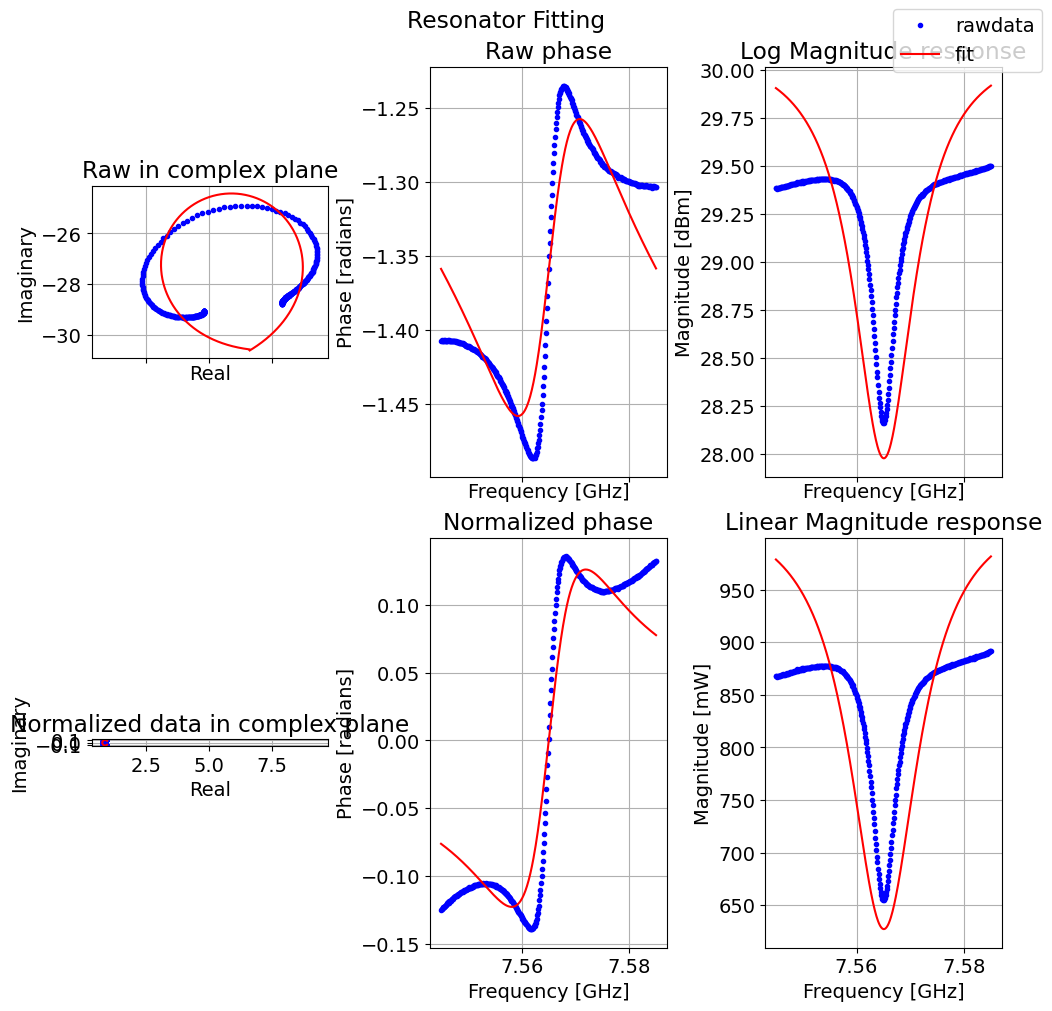


Fit at V dBm
Frequency: 7.5651 GHz
Total Q: 484
Internal Q: 621
Coupling Q: 2190
FWHM: 15.63000 MHz
Kappa: 98.20619 MHz
Single Photon Power: -122.5 dBm
Ringdown Time: 0.014 us
Impedance Mismatch -0.775 degrees
Electrical Delay: 0.611742 ns
SNR: 0.1

Q_ext = [2190.231131290036], Q_int = [621.3174891237654], Q_tot = [484.0140046710427]


Log File: G:\Shared drives\Labber\Data\2024\04\Data_0425\\profile_info_highQ-resonators-round3-chipA-res9.log

Plots Directory: G:\Shared drives\Labber\Data\2024\04\Data_0425\\figures\highQ-resonators-round3-chipA-res9.\


<Figure size 900x600 with 0 Axes>

In [14]:
res=9
fpath = f'G:\\Shared drives\\Labber\Data\\2024\\04\\Data_0425\\highQ-resonators-round3-chipA-res{res}.hdf5'
fit_resonator(fpath,res_type="n")